In [1]:
import filehandling
import pandas as pd
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def get_delaunay_vectors(points):
    tri = spatial.Delaunay(points[['x', 'y']])
    triangles = tri.points[tri.simplices]
    vecs = np.array([t-t[[2, 0, 1], :] for t in triangles])
    vecs = vecs.reshape((-1, 2))
    return vecs

def get_delaunay_angles(vecs):
    return np.arctan(vecs[:, 1]/vecs[:, 0])


def get_delaunay_lengths(vecs):
    lengths = np.linalg.norm(vecs, axis=1)
    return lengths

In [3]:
def calculate_G(length, angle):
    a = angle + np.pi/2
    cosa = np.cos(a)
    sina = np.sin(a)
    l = 4 * np.pi / (length * np.sqrt(3))
    return np.array((cosa, sina))*l

In [4]:
def calculate_torder_from_length_and_angle(length, angle):
    G = calculate_G(length, angle)
    return np.exp(1j*frame[['x', 'y']].values@G)

In [5]:
def get_initial_length_and_angle(frame, apothem=False):
    vecs = get_delaunay_vectors(frame)
    angles = get_delaunay_angles(vecs)
    if apothem:
        angle = np.median(angles[angles>0])
    else:
        angle = np.median(angles[angles>0.5])
    lengths = get_delaunay_lengths(vecs)
    length = np.median(lengths)
    return length, angle


In [61]:
direc = "/media/data/Data/BallBearing/HIPS/PhaseDiagramsNewPlate/2,42mm/80%"
data_files = filehandling.list_files(f'{direc}/*.hdf5')

In [62]:
def get_frame(file):
    data = pd.read_hdf(file)
    return data.loc[0].copy()

file = data_files[1]
frame =get_frame(file)

In [63]:
frame = frame.copy()

In [64]:
def get_neighbours_indices(frame, n):
    tree = spatial.KDTree(frame[['x', 'y']].values)
    dists, indices = tree.query(frame[['x', 'y']].values, n)
    return indices

In [65]:
neighbours_50 = get_neighbours_indices(frame, 50)
neighbours_50

array([[   0,    4,    8, ...,  168,  143,  321],
       [   1,   24,   80, ...,  283,  161,  376],
       [   2,    9,   60, ...,  318,  178,  323],
       ...,
       [7890, 7846, 7892, ..., 7508, 7628, 7732],
       [7891, 7835, 7854, ..., 7563, 7815, 7696],
       [7892, 7854, 7823, ..., 7609, 7889, 7538]])

In [66]:
def get_torder_std_of_n_neighbours(l, a):
    G = calculate_G(l, a)
    torder = np.exp(1j*frame[['x', 'y']].values@G)
    angles = np.angle(torder)
    angles_all = angles[neighbours_50]
    angles_stds = np.std(angles_all, axis=1)
    std = np.mean(angles_stds)
    return std
torder_angle_neighbour_vec = np.vectorize(get_torder_std_of_n_neighbours)

In [67]:
length, angle = get_initial_length_and_angle(frame, False)

In [68]:
get_torder_std_of_n_neighbours(length, angle)

1.7968195716909612

In [69]:
def refine_l_and_a(l, a, plot=False, width=0.05):
    lengths = np.linspace((1-width)*l, (1+width)*l, 100)
    angles = np.linspace((1-width)*a, (1+width)*a, 100)
    lengths, angles = np.meshgrid(lengths, angles)
    stds = torder_angle_neighbour_vec(lengths, angles)
    min_index = np.unravel_index(np.argmin(stds, axis=None), stds.shape)
    new_length = lengths[min_index]
    new_angle = angles[min_index]
    return new_length, new_angle

In [70]:
length2, angle2 = refine_l_and_a(length, angle, width=0.5)
length3, angle3 = refine_l_and_a(length2, angle2, width=0.1)

In [71]:
refined_torder = calculate_torder_from_length_and_angle(length3, angle3)

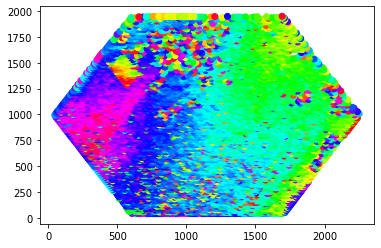

In [30]:
plt.scatter(frame.x, frame.y, c=np.angle(refined_torder), cmap='hsv')

## Standard deviations

In [72]:
def get_std_frame(df):
    frame = df.loc[0]
    neighbours = get_neighbours_indices(frame, 50)
    orders = np.abs(frame.torder.values)
    orders_all = orders[neighbours]
    orders_std = np.std(orders_all, axis=1)
    std = np.mean(orders_std)
    return std

def get_torder(df, l, a):
    G = calculate_G(l, a)
    return np.exp(1j*df[['x', 'y']].values@G)


In [75]:
duties = []
torders = []
horders = []
for file in tqdm(data_files):
    data = pd.read_hdf(file)
    data['torder'] = get_torder(data, length3, angle3)
    frame = data
    torder = frame.torder.values
    horder = frame.hexatic_order.values
    torder_mean = np.mean(np.abs(torder))
    horder_mean = np.mean(np.abs(horder))
    duty = int(file[-8:-5])
    duties.append(duty)
    torders.append(torder_mean)
    horders.append(horder_mean)

100%|██████████| 94/94 [00:49<00:00,  1.91it/s]


In [77]:
np.abs(torder)

array([1., 1., 1., ..., 1., 1., 1.])

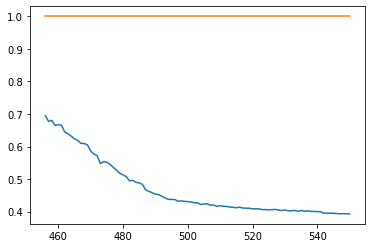

In [78]:
plt.plot(duties, horders)
plt.plot(duties,  torders)

## Chop up areas

<AxesSubplot:xlabel='x', ylabel='y'>

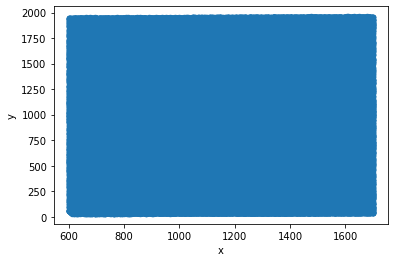

In [91]:
square_region = frame[(frame.x>600)*(frame.x<1700)]
square_region.plot(x='x', y='y', kind='scatter')

In [98]:

def mean_frame_values(points, param):
    vals = points[param].values
    return np.mean(vals)

def get_sus(df):
    means_t = df.groupby('frame').apply(mean_frame_values, 'torder')
    sus_t = np.mean(np.abs(means_t**2)) - np.mean(np.abs(means_t))**2
    means_h = df.groupby('frame').apply(mean_frame_values, 'hexatic_order')
    sus_h = np.mean(np.abs(means_h**2)) - np.mean(np.abs(means_h))**2
    return sus_h, sus_t

In [111]:
xmin = square_region.x.min()
xmax = square_region.x.max()
ymin = square_region.y.min()
ymax = square_region.y.max()
s = square_region
Ns = []
sus_h_N = []
sus_t_N = []
for N in tqdm([ 2, 3, 4, 5, 6, 7, 8 ,9, 10]):
    dx = np.linspace(xmin, xmax, N)
    dy = np.linspace(ymin, ymax, N)
    dx, dy = np.meshgrid(dx, dy)
    A = (dx[1, 1]-dx[0, 0])*(dy[1, 1]-dy[0, 0])
    sushs= []
    susts = []
    for i in range(len(dx)-1):
        for j in range(len(dx[0])-1):
            region = s[(s.x>dx[i, j])*(s.x<dx[i+1, j+1])*(s.y>dy[i, j])*(s.y<dy[i+1, j+1])]
            # plt.scatter(region.x, region.y)
            sus_h, sus_t = get_sus(region)
            sushs.append(sus_h)
            susts.append(sus_t)
    sus_h_N.append(np.mean(sushs)*A)
    sus_t_N.append(np.mean(susts)*A)
    Ns.append(N)

100%|██████████| 9/9 [00:03<00:00,  2.48it/s]


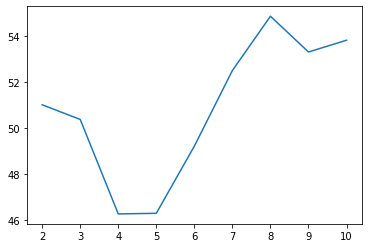

In [115]:
plt.plot(Ns, sus_h_N)
# plt.plot(Ns, sus_t_N)